In [1]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 7
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

base_day = 30
prediction_day = base_day
slide = base_day

# Import packages


In [2]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

# Load data


In [3]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d').date()
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')
    all_data.index = all_data.index.date
    check = date_predict_start in all_data.index
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)
    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(test_data['data_' + str(i)].index[0])
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['data_' + str(i)] = train_data['data_' +
                                                  str(i)].reset_index(drop=False)
        test_data['data_' + str(i)] = test_data['data_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


# Data preprocessing


In [4]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [5]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range and idx>0:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [6]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)
    else :
        print('worng pv_method')


# Built Model


Get signal


In [7]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # get harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [8]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            # for j in range(n_harm):
            for j in range(2, n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [9]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range and idx>0:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peak'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valley'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valley'


In [10]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [11]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [12]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            else :
                print('worng fit_method')
            errors[i][j] = error
    return errors


In [13]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        best_error[i] = pd.Series(errors[i]).abs().min()
        best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
    return best_fit_harm, best_error


In [14]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [15]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [16]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [17]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [18]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [19]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [20]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [21]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valleys'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valleys'


In [22]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data_copy = test_data.copy()
    for d in test_data :
        test_data_copy[d].index = test_data[d]['index']
        test_data_copy[d] = test_data_copy[d].drop(test_data_copy[d][test_data_copy[d].index > date_list[-1]].index)
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['Close'], 'gray', label='data', linewidth=3)
    for d in test_data_copy :
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [23]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    # return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [24]:
# main_funtion(
#     stock_name, date_predict_start, data_range, slide_range,
#         n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)

# Lstm function

In [25]:
def preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide):
    x_train = {}
    y_train = {}
    for i in train_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled_data = scaler.fit_transform(train_data[i]['Close'].values.reshape(-1,1))
        x_train[i] = []
        y_train[i] = []
        # for x in range(base_day+prediction_day, len(scaled_data), slide):
        for x in range(base_day+prediction_day, len(scaled_data)):
            x_train[i].append(scaled_data[x-base_day-prediction_day:x-prediction_day])
            y_train[i].append(scaled_data[x-prediction_day:x])
        x_train[i], y_train[i] = np.array(x_train[i]), np.array(y_train[i])
        # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
        x_train[i] = np.reshape(x_train[i], (x_train[i].shape[0], x_train[i].shape[1], 1))
        y_train[i] = np.reshape(y_train[i], (y_train[i].shape[0], y_train[i].shape[1], 1))
    return x_train, y_train

In [26]:
def LSTM_model(prediction_day, input_shape):
    model = Sequential()
    model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.4))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.4))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.4))
    model.add(Dense(units=prediction_day))
    return model

In [27]:
def build_Lstm_model(train_data, prediction_day, input_shape):
    model = {}
    for i in train_data:
        model[i] = LSTM_model(prediction_day, input_shape)
        model[i].compile(optimizer='adam', 
                    loss='mean_squared_error')
        # model[i].summary()
    return model

In [28]:
def train_Lstm_model(train_data, model, x_train, y_train):
    history = {}
    for i in tqdm(train_data):
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history[i] = model[i].fit(x_train[i], y_train[i], epochs=25, batch_size=32, 
                            callbacks = [earlystopper], validation_split = 0.2, shuffle=True)
    return history

In [29]:
def preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide):
    x_test = {}
    y_test = {}
    for i in test_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        model_inputs = pd.concat((train_data[i]['Close'].iloc[-base_day:], test_data[i]['Close'])).values
        model_inputs = model_inputs.reshape(-1,1)
        model_inputs = scaler.fit_transform(model_inputs)
        x_test[i] = []
        y_test[i] = []
        for x in range(base_day+prediction_day, len(model_inputs), slide):
            x_test[i].append(model_inputs[x-base_day-prediction_day:x-prediction_day])
            y_test[i].append(model_inputs[x-prediction_day:x])
        x_test[i], y_test[i] = np.array(x_test[i]), np.array(y_test[i])
        x_test[i] = np.reshape(x_test[i], (x_test[i].shape[0], x_test[i].shape[1], 1))
        y_test[i] = np.reshape(y_test[i], (y_test[i].shape[0], y_test[i].shape[1], 1))
    return x_test, y_test

In [30]:
def predicting_creat_processed_signal_Lstm(x_test, test_data, model):
    processed_signal = {}
    for i in test_data:
        predicted_prices = model[i].predict(x_test[i])
        processed_signal[i] = {}
        processed_signal[i][0] = pd.DataFrame(
            {'Close': predicted_prices.flatten()}, index=test_data[i].index[:len(predicted_prices.flatten())])
    return processed_signal

In [31]:
def result_table_process_Lstm_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i]].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [32]:
# 1. Load data
train_data, test_data, all_data, test_data_start_list = load_data(
    stock_name, date_predict_start, data_range, slide_range, n_slide)
# 2. Preprocessing
preprocessing(train_data, test_data, pv_range, pv_method)
x_train, y_train = preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide)
x_test, y_test = preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/25
5/5 [==============================] - 38s 2s/step - loss: 0.0403 - val_loss: 0.2383
Epoch 2/25
5/5 [==============================] - 1s 238ms/step - loss: 0.0359 - val_loss: 0.2448
Epoch 3/25
5/5 [==============================] - 1s 213ms/step - loss: 0.0340 - val_loss: 0.2125
Epoch 4/25
5/5 [==============================] - 1s 215ms/step - loss: 0.0309 - val_loss: 0.2093
Epoch 5/25
5/5 [==============================] - 1s 205ms/step - loss: 0.0296 - val_loss: 0.2043
Epoch 6/25
5/5 [==============================] - 1s 218ms/step - loss: 0.0280 - val_loss: 0.2079
Epoch 7/25
5/5 [==============================] - 1s 182ms/step - loss: 0.0284 - val_loss: 0.2388
Epoch 8/25
5/5 [==============================] - 1s 191ms/step - loss: 0.0268 - val_loss: 0.2056
Epoch 9/25
5/5 [==============================] - 1s 233ms/step - loss: 0.0262 - val_loss: 0.1971
Epoch 10/25
5/5 [==============================] - 1s 235ms/step - loss: 0.0255 - val_loss: 0.1910
Epoch 11/25
5/5 [====

 10%|█         | 1/10 [00:58<08:45, 58.41s/it]

Epoch 1/25
5/5 [==============================] - 47s 2s/step - loss: 0.0499 - val_loss: 0.2726
Epoch 2/25
5/5 [==============================] - 2s 359ms/step - loss: 0.0441 - val_loss: 0.2731
Epoch 3/25
5/5 [==============================] - 1s 270ms/step - loss: 0.0435 - val_loss: 0.2724
Epoch 4/25
5/5 [==============================] - 1s 275ms/step - loss: 0.0418 - val_loss: 0.2747
Epoch 5/25
5/5 [==============================] - 1s 261ms/step - loss: 0.0407 - val_loss: 0.2746
Epoch 6/25
5/5 [==============================] - 1s 251ms/step - loss: 0.0395 - val_loss: 0.2611
Epoch 7/25
5/5 [==============================] - 1s 253ms/step - loss: 0.0394 - val_loss: 0.2533
Epoch 8/25
5/5 [==============================] - 1s 262ms/step - loss: 0.0382 - val_loss: 0.2575
Epoch 9/25
5/5 [==============================] - 1s 253ms/step - loss: 0.0372 - val_loss: 0.2521
Epoch 10/25
5/5 [==============================] - 1s 212ms/step - loss: 0.0365 - val_loss: 0.2460
Epoch 11/25
5/5 [====

 20%|██        | 2/10 [02:06<08:31, 63.99s/it]

Epoch 1/25
5/5 [==============================] - 47s 2s/step - loss: 0.1006 - val_loss: 0.3012
Epoch 2/25
5/5 [==============================] - 1s 292ms/step - loss: 0.0728 - val_loss: 0.3005
Epoch 3/25
5/5 [==============================] - 1s 289ms/step - loss: 0.0684 - val_loss: 0.2979
Epoch 4/25
5/5 [==============================] - 1s 306ms/step - loss: 0.0645 - val_loss: 0.3129
Epoch 5/25
5/5 [==============================] - 1s 272ms/step - loss: 0.0614 - val_loss: 0.3158
Epoch 6/25
5/5 [==============================] - 1s 280ms/step - loss: 0.0600 - val_loss: 0.3066
Epoch 7/25
5/5 [==============================] - 1s 279ms/step - loss: 0.0614 - val_loss: 0.2978
Epoch 8/25
5/5 [==============================] - 2s 301ms/step - loss: 0.0568 - val_loss: 0.2640
Epoch 9/25
5/5 [==============================] - 1s 281ms/step - loss: 0.0571 - val_loss: 0.2271
Epoch 10/25
5/5 [==============================] - 1s 279ms/step - loss: 0.0551 - val_loss: 0.2357
Epoch 11/25
5/5 [====

 30%|███       | 3/10 [03:31<08:34, 73.49s/it]

Epoch 1/25
5/5 [==============================] - 48s 4s/step - loss: 0.1517 - val_loss: 0.2850
Epoch 2/25
5/5 [==============================] - 1s 270ms/step - loss: 0.1042 - val_loss: 0.2966
Epoch 3/25
5/5 [==============================] - 1s 269ms/step - loss: 0.0922 - val_loss: 0.2587
Epoch 4/25
5/5 [==============================] - 1s 269ms/step - loss: 0.0831 - val_loss: 0.2713
Epoch 5/25
5/5 [==============================] - 1s 281ms/step - loss: 0.0827 - val_loss: 0.2452
Epoch 6/25
5/5 [==============================] - 1s 286ms/step - loss: 0.0794 - val_loss: 0.2430
Epoch 7/25
5/5 [==============================] - 2s 333ms/step - loss: 0.0753 - val_loss: 0.2262
Epoch 8/25
5/5 [==============================] - 2s 352ms/step - loss: 0.0726 - val_loss: 0.2157
Epoch 9/25
5/5 [==============================] - 1s 238ms/step - loss: 0.0692 - val_loss: 0.1882
Epoch 10/25
5/5 [==============================] - 1s 229ms/step - loss: 0.0673 - val_loss: 0.1636
Epoch 11/25
5/5 [====

 40%|████      | 4/10 [04:43<07:17, 72.90s/it]

Epoch 1/25
5/5 [==============================] - 46s 916ms/step - loss: 0.1477 - val_loss: 0.3526
Epoch 2/25
5/5 [==============================] - 1s 232ms/step - loss: 0.1069 - val_loss: 0.3415
Epoch 3/25
5/5 [==============================] - 1s 213ms/step - loss: 0.0985 - val_loss: 0.3050
Epoch 4/25
5/5 [==============================] - 1s 221ms/step - loss: 0.0910 - val_loss: 0.2880
Epoch 5/25
5/5 [==============================] - 1s 208ms/step - loss: 0.0842 - val_loss: 0.2489
Epoch 6/25
5/5 [==============================] - 1s 213ms/step - loss: 0.0814 - val_loss: 0.2164
Epoch 7/25
5/5 [==============================] - 1s 269ms/step - loss: 0.0765 - val_loss: 0.1684
Epoch 8/25
5/5 [==============================] - 1s 252ms/step - loss: 0.0781 - val_loss: 0.1218
Epoch 9/25
5/5 [==============================] - 1s 214ms/step - loss: 0.0732 - val_loss: 0.0907
Epoch 10/25
5/5 [==============================] - 1s 212ms/step - loss: 0.0716 - val_loss: 0.0538
Epoch 11/25
5/5 [=

 50%|█████     | 5/10 [05:47<05:49, 69.92s/it]

Epoch 1/25
5/5 [==============================] - 40s 2s/step - loss: 0.0638 - val_loss: 0.3430
Epoch 2/25
5/5 [==============================] - 1s 242ms/step - loss: 0.0483 - val_loss: 0.2403
Epoch 3/25
5/5 [==============================] - 1s 242ms/step - loss: 0.0423 - val_loss: 0.1317
Epoch 4/25
5/5 [==============================] - 1s 238ms/step - loss: 0.0379 - val_loss: 0.0955
Epoch 5/25
5/5 [==============================] - 1s 256ms/step - loss: 0.0368 - val_loss: 0.1117
Epoch 6/25
5/5 [==============================] - 1s 294ms/step - loss: 0.0365 - val_loss: 0.1438
Epoch 7/25
5/5 [==============================] - 1s 216ms/step - loss: 0.0330 - val_loss: 0.1401
Epoch 8/25
5/5 [==============================] - 1s 257ms/step - loss: 0.0321 - val_loss: 0.1433
Epoch 9/25
5/5 [==============================] - 1s 283ms/step - loss: 0.0327 - val_loss: 0.1476
Epoch 9: early stopping


 60%|██████    | 6/10 [06:38<04:13, 63.34s/it]

Epoch 1/25
5/5 [==============================] - 39s 1s/step - loss: 0.1445 - val_loss: 0.4084
Epoch 2/25
5/5 [==============================] - 1s 257ms/step - loss: 0.0883 - val_loss: 0.2820
Epoch 3/25
5/5 [==============================] - 1s 260ms/step - loss: 0.0670 - val_loss: 0.2421
Epoch 4/25
5/5 [==============================] - 1s 267ms/step - loss: 0.0558 - val_loss: 0.2335
Epoch 5/25
5/5 [==============================] - 1s 237ms/step - loss: 0.0503 - val_loss: 0.2242
Epoch 6/25
5/5 [==============================] - 1s 226ms/step - loss: 0.0448 - val_loss: 0.2238
Epoch 7/25
5/5 [==============================] - 1s 245ms/step - loss: 0.0431 - val_loss: 0.2499
Epoch 8/25
5/5 [==============================] - 1s 239ms/step - loss: 0.0396 - val_loss: 0.2439
Epoch 9/25
5/5 [==============================] - 1s 221ms/step - loss: 0.0358 - val_loss: 0.2694
Epoch 10/25
5/5 [==============================] - 1s 268ms/step - loss: 0.0318 - val_loss: 0.3126
Epoch 11/25
5/5 [====

 70%|███████   | 7/10 [07:29<02:58, 59.42s/it]

Epoch 1/25
5/5 [==============================] - 33s 1s/step - loss: 0.1590 - val_loss: 0.5189
Epoch 2/25
5/5 [==============================] - 1s 234ms/step - loss: 0.0865 - val_loss: 0.3834
Epoch 3/25
5/5 [==============================] - 1s 219ms/step - loss: 0.0716 - val_loss: 0.4483
Epoch 4/25
5/5 [==============================] - 1s 215ms/step - loss: 0.0557 - val_loss: 0.4379
Epoch 5/25
5/5 [==============================] - 1s 217ms/step - loss: 0.0464 - val_loss: 0.5383
Epoch 6/25
5/5 [==============================] - 1s 231ms/step - loss: 0.0468 - val_loss: 0.4802
Epoch 7/25
5/5 [==============================] - 1s 250ms/step - loss: 0.0390 - val_loss: 0.6176
Epoch 7: early stopping


 80%|████████  | 8/10 [08:09<01:46, 53.10s/it]

Epoch 1/25
5/5 [==============================] - 27s 1s/step - loss: 0.2127 - val_loss: 0.7410
Epoch 2/25
5/5 [==============================] - 1s 241ms/step - loss: 0.1270 - val_loss: 0.5702
Epoch 3/25
5/5 [==============================] - 1s 248ms/step - loss: 0.0923 - val_loss: 0.6565
Epoch 4/25
5/5 [==============================] - 1s 232ms/step - loss: 0.0737 - val_loss: 0.8551
Epoch 5/25
5/5 [==============================] - 1s 222ms/step - loss: 0.0634 - val_loss: 0.7814
Epoch 6/25
5/5 [==============================] - 1s 226ms/step - loss: 0.0623 - val_loss: 0.8810
Epoch 7/25
5/5 [==============================] - 1s 249ms/step - loss: 0.0581 - val_loss: 0.9379
Epoch 7: early stopping


 90%|█████████ | 9/10 [08:42<00:47, 47.01s/it]

Epoch 1/25
5/5 [==============================] - 24s 716ms/step - loss: 0.2278 - val_loss: 0.6118
Epoch 2/25
5/5 [==============================] - 1s 160ms/step - loss: 0.1272 - val_loss: 0.6030
Epoch 3/25
5/5 [==============================] - 1s 198ms/step - loss: 0.0988 - val_loss: 0.7488
Epoch 4/25
5/5 [==============================] - 1s 188ms/step - loss: 0.0732 - val_loss: 0.9010
Epoch 5/25
5/5 [==============================] - 1s 204ms/step - loss: 0.0712 - val_loss: 0.8638
Epoch 6/25
5/5 [==============================] - 1s 189ms/step - loss: 0.0669 - val_loss: 0.8262
Epoch 7/25
5/5 [==============================] - 1s 206ms/step - loss: 0.0636 - val_loss: 0.8978
Epoch 7: early stopping


100%|██████████| 10/10 [09:12<00:00, 55.29s/it]


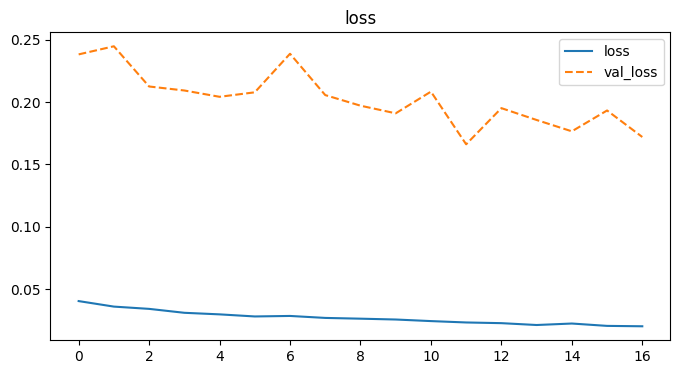

1/1 [==============================] - 2s 2s/step


In [33]:
# 3. Build model
# harmonics, model = build_model(
    # train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
# harmonics = data_to_harmonics_function(train_data, data_range)
# processed_signal_FFT = mix_harmonics_function(
#     harmonics, n_harm_lower_limit, n_harm_upper_limit)
# processed_signal = processed_signal_FFT

input_shape = (x_train[list(x_train.keys())[0]].shape[1],1)
model = build_Lstm_model(train_data, prediction_day, input_shape)

history = train_Lstm_model(train_data, model, x_train, y_train)
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history['data_0'].history['loss'], label='loss')
plt.plot(history['data_0'].history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()
processed_signal = predicting_creat_processed_signal_Lstm(x_test, test_data, model)
find_signal_pv_function(processed_signal, pv_range)
find_signal_lead_train_function(train_data, processed_signal)

In [34]:
# 4. Select model
# errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
#                                                                         model, fit_method)
errors = get_fit_error_function(processed_signal, fit_method)
best_fit_harm, best_error = get_best_fit_harm_function(
    processed_signal, errors)
find_signal_lead_test_function(test_data, processed_signal)
first_date, lead, pv = get_first_lead_function(
    processed_signal, best_fit_harm)


In [35]:
# 5. Evaluate model
# result_table, final_error = evaluate_model(
#     model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
result_table_process_Lstm_function(
    result_table, all_data, first_date, data_range)
final_error = compute_final_error_function(result_table)
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

final_error =  10.0
            s_date      t_date  lead    ans_date      pv  error best_fit
data_0  2020-01-02  2020-01-28   3.0  2020-01-31  valley   8.44        0
data_1  2020-01-16  2020-01-17  21.0  2020-02-19    peak  11.37        0
data_2  2020-01-31  2020-02-05   9.0  2020-02-19    peak  10.66        0
data_3  2020-02-14  2020-02-20  22.0  2020-03-23  valley  10.81        0
data_4  2020-03-02  2020-03-16   5.0  2020-03-23  valley   11.2        0
data_5  2020-03-16  2020-03-17   4.0  2020-03-23  valley   8.92        0
data_6  2020-03-30  2020-04-01   0.0  2020-04-01  valley  11.42        0
data_7  2020-04-14  2020-04-30  -7.0  2020-04-21  valley   9.93        0
data_8  2020-04-28  2020-05-01  25.0  2020-06-08    peak  10.21        0
data_9  2020-05-12  2020-05-19  -4.0  2020-05-13  valley  10.22        0


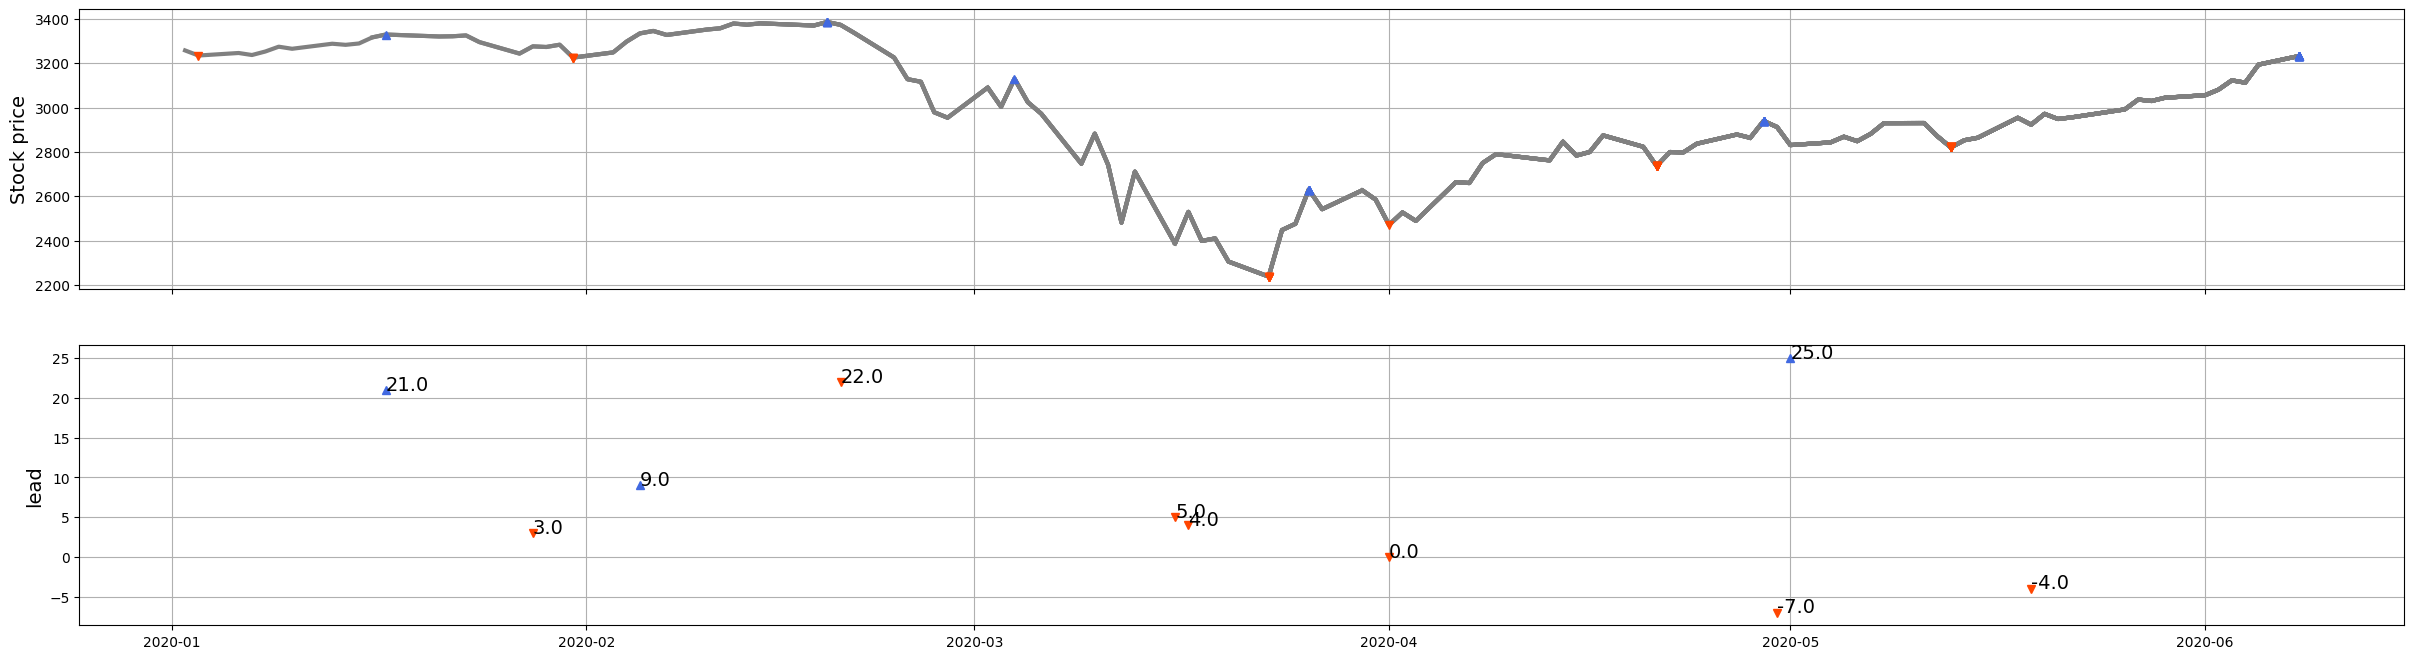

In [36]:
draw_plot_result_table(test_data, all_data, result_table, pv_range)

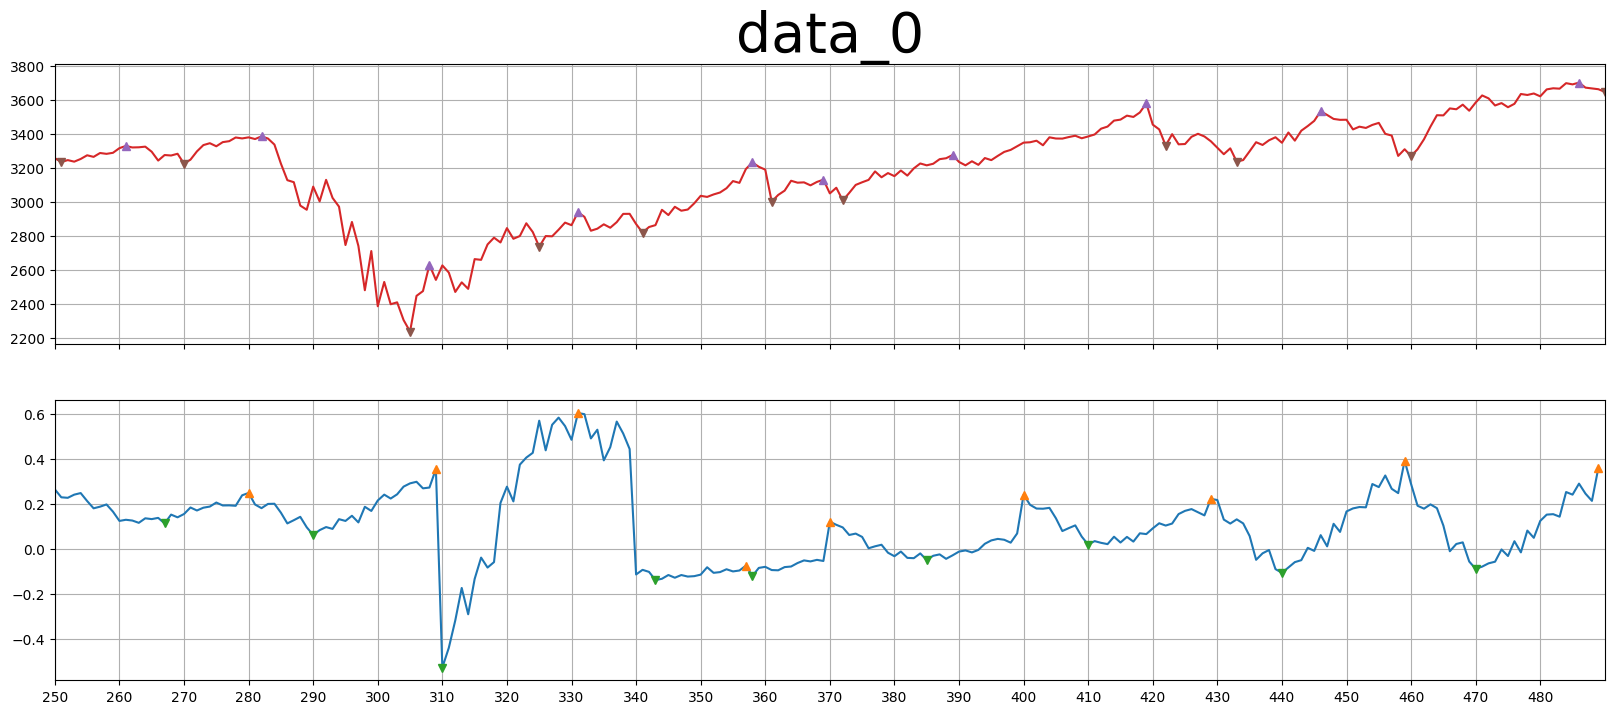

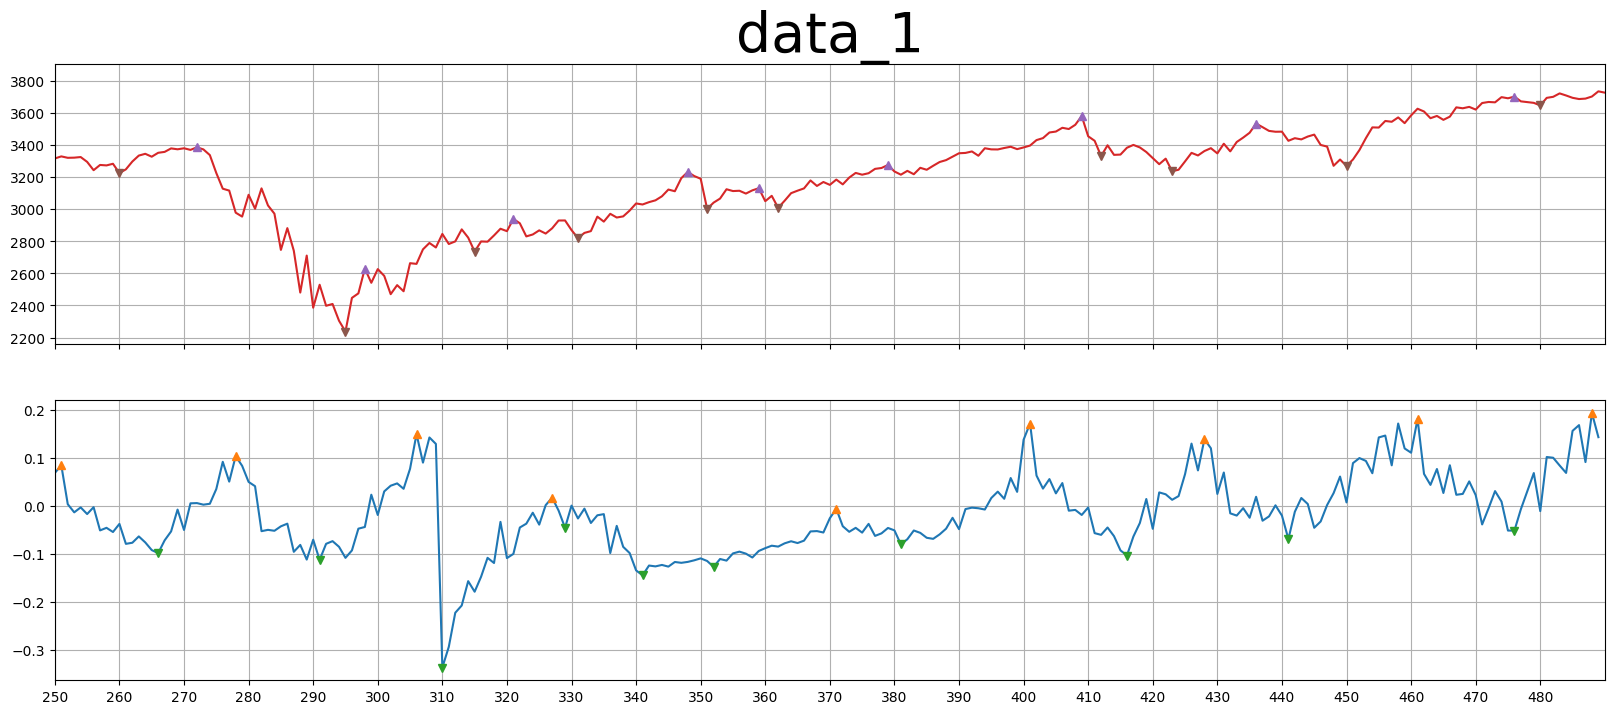

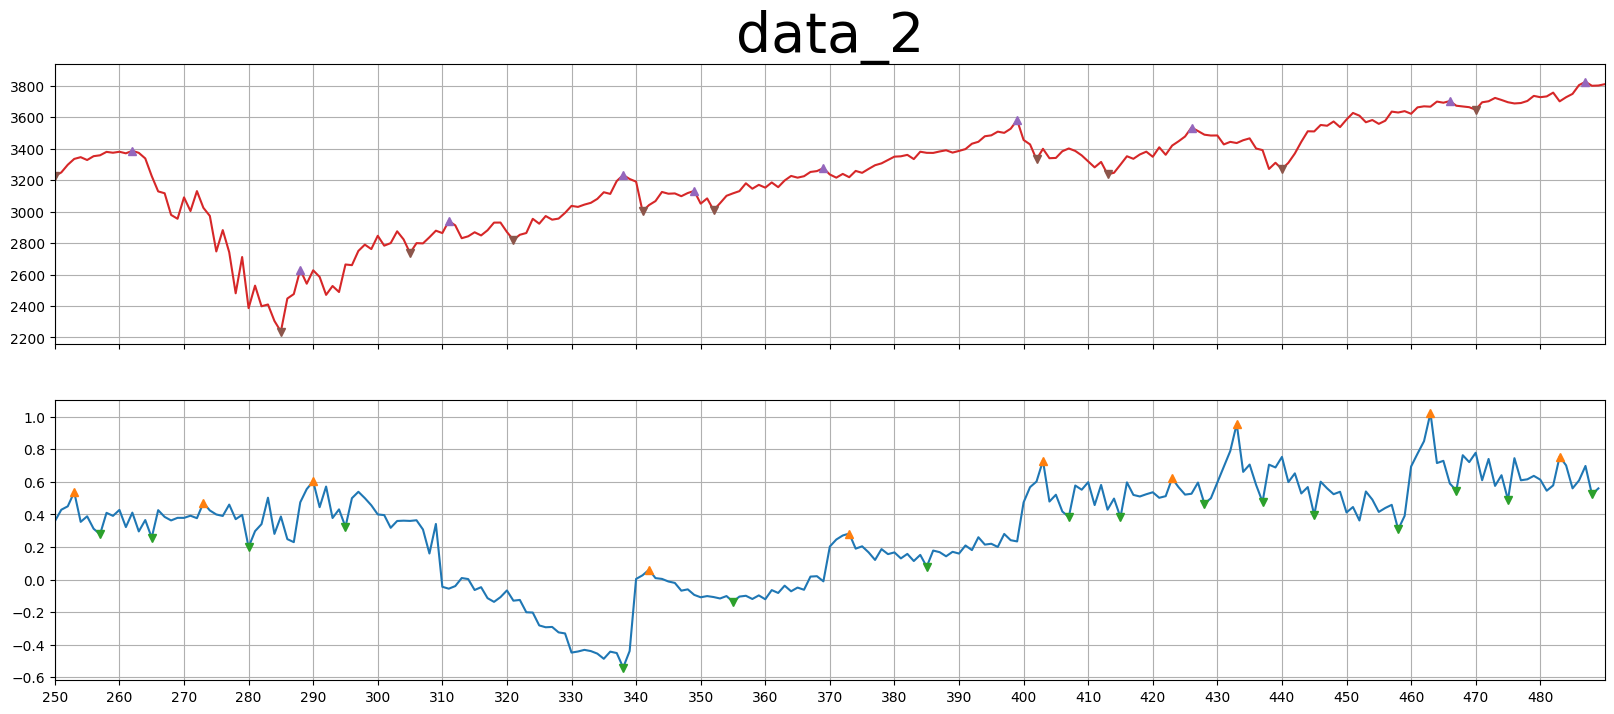

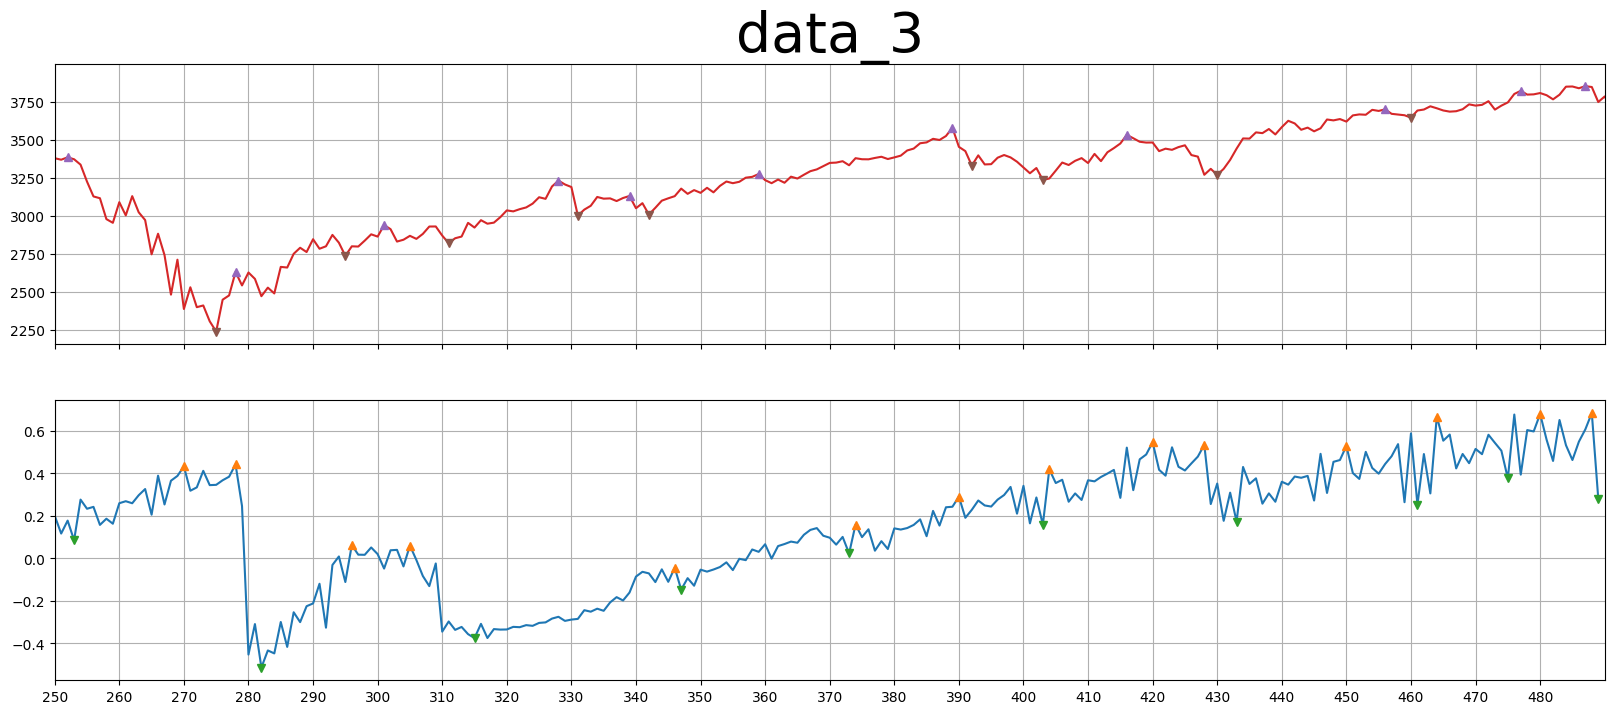

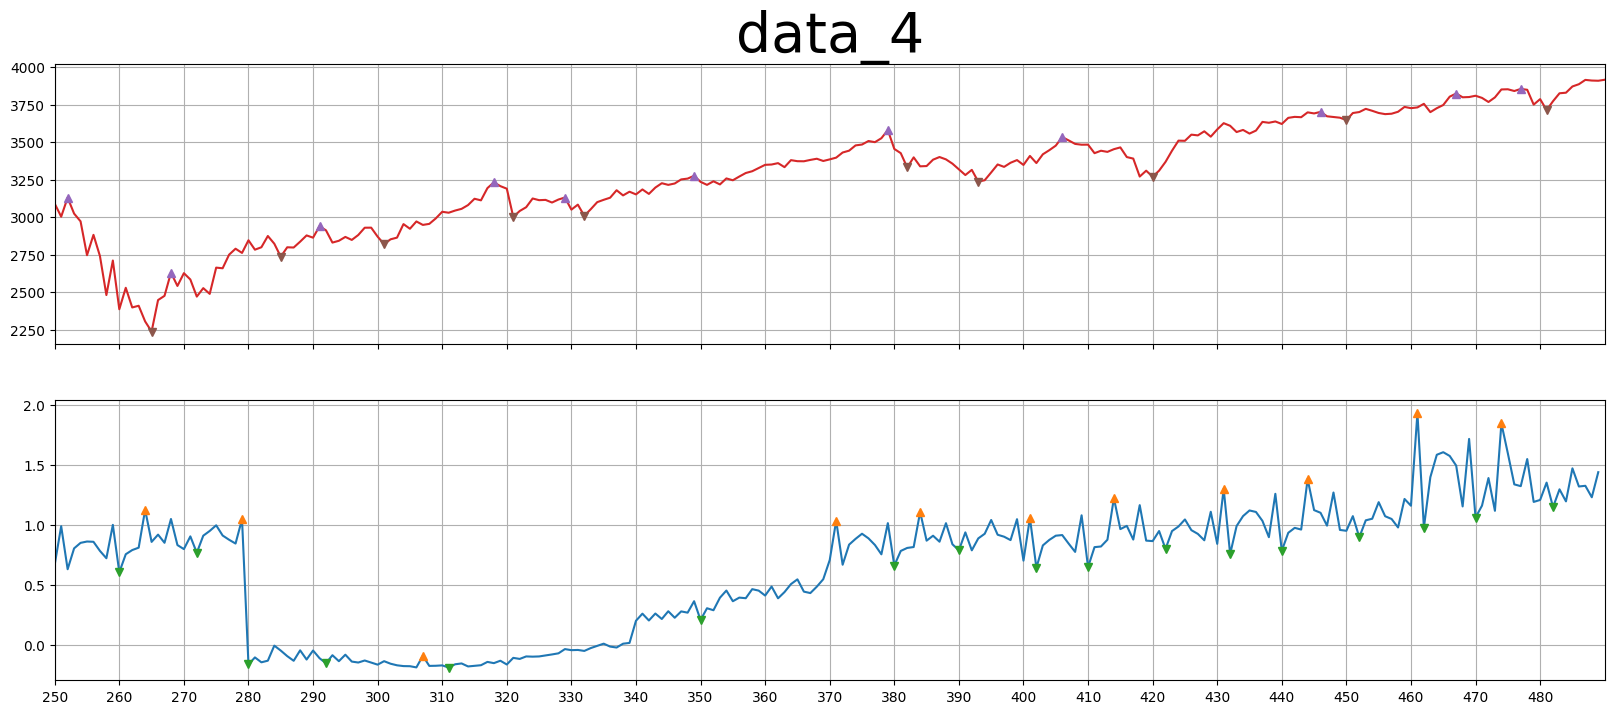

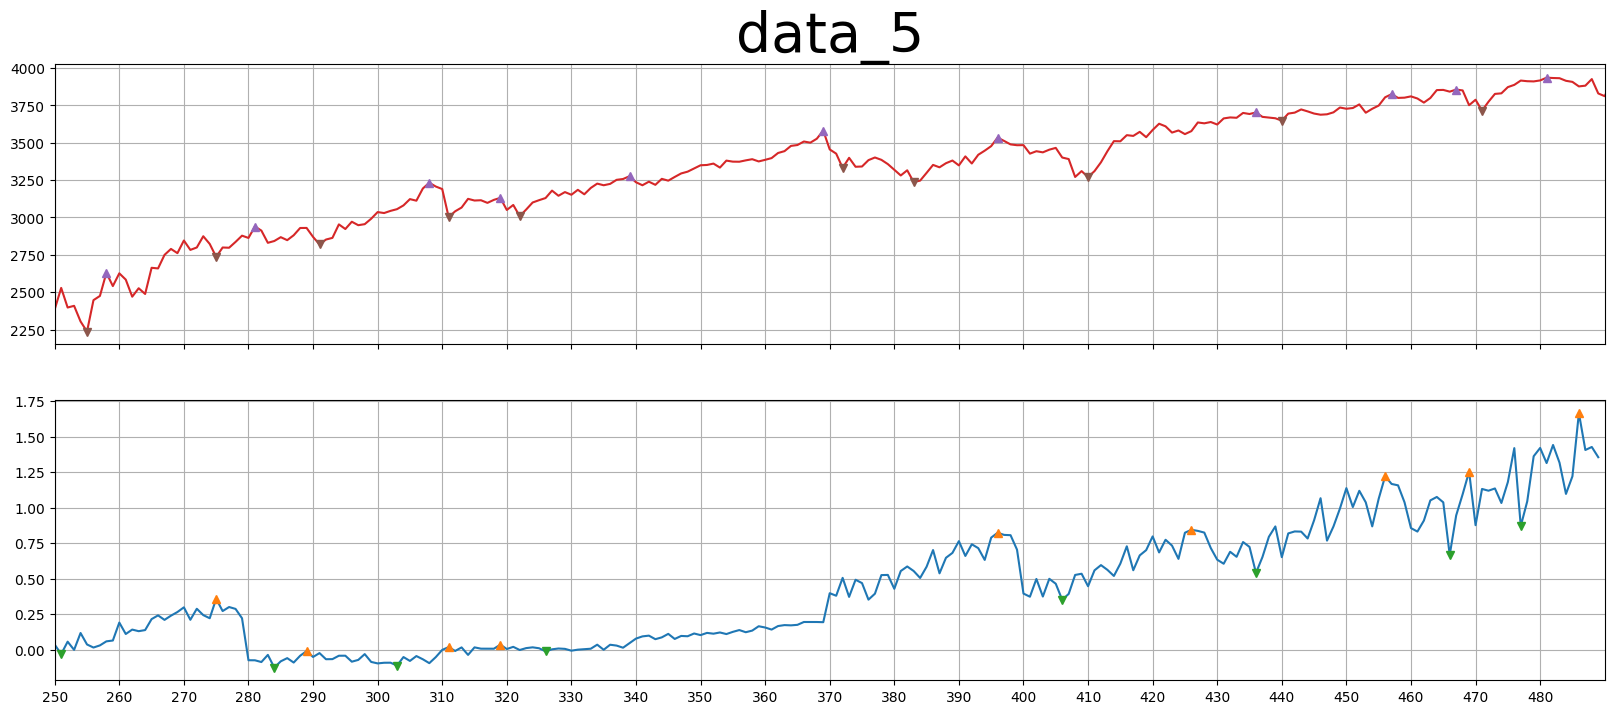

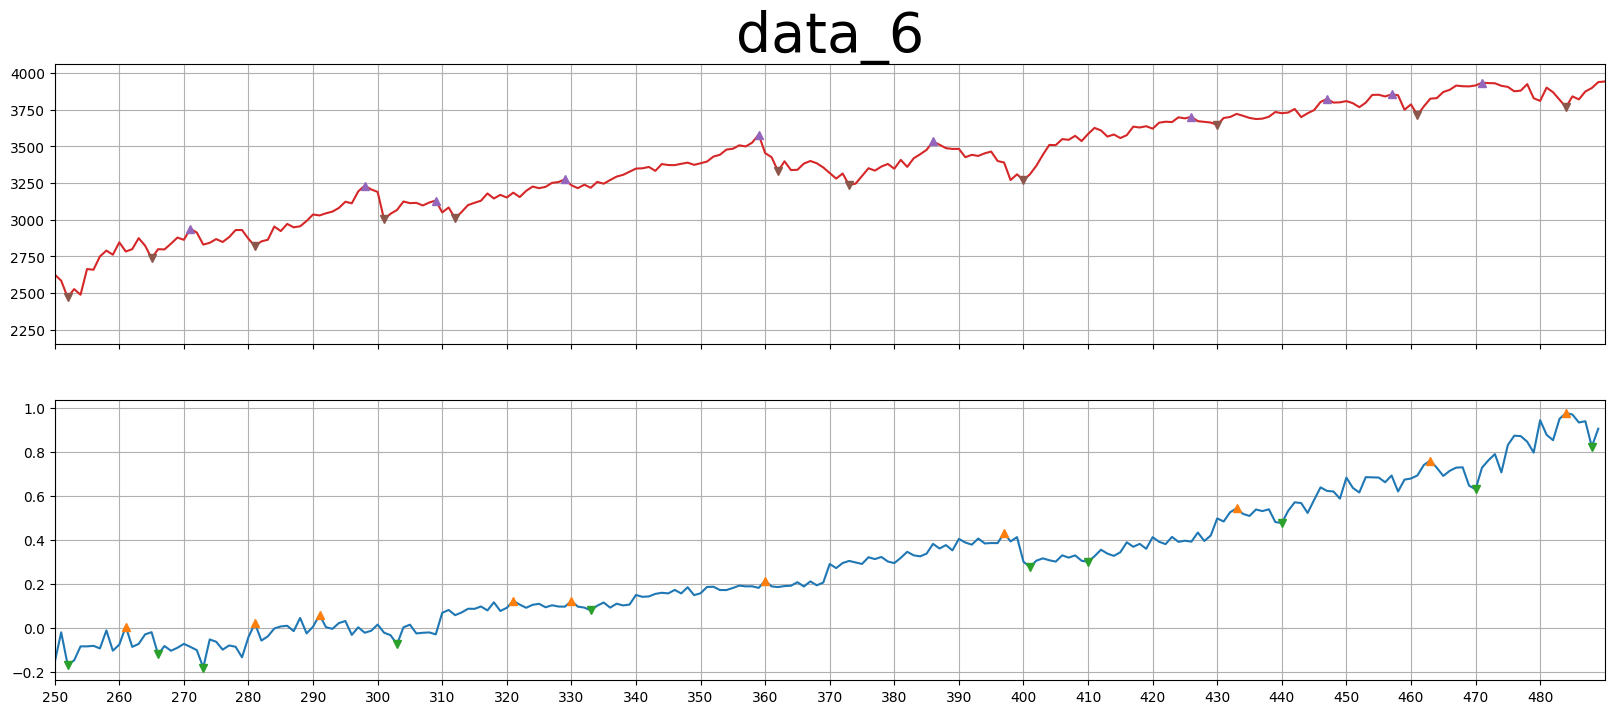

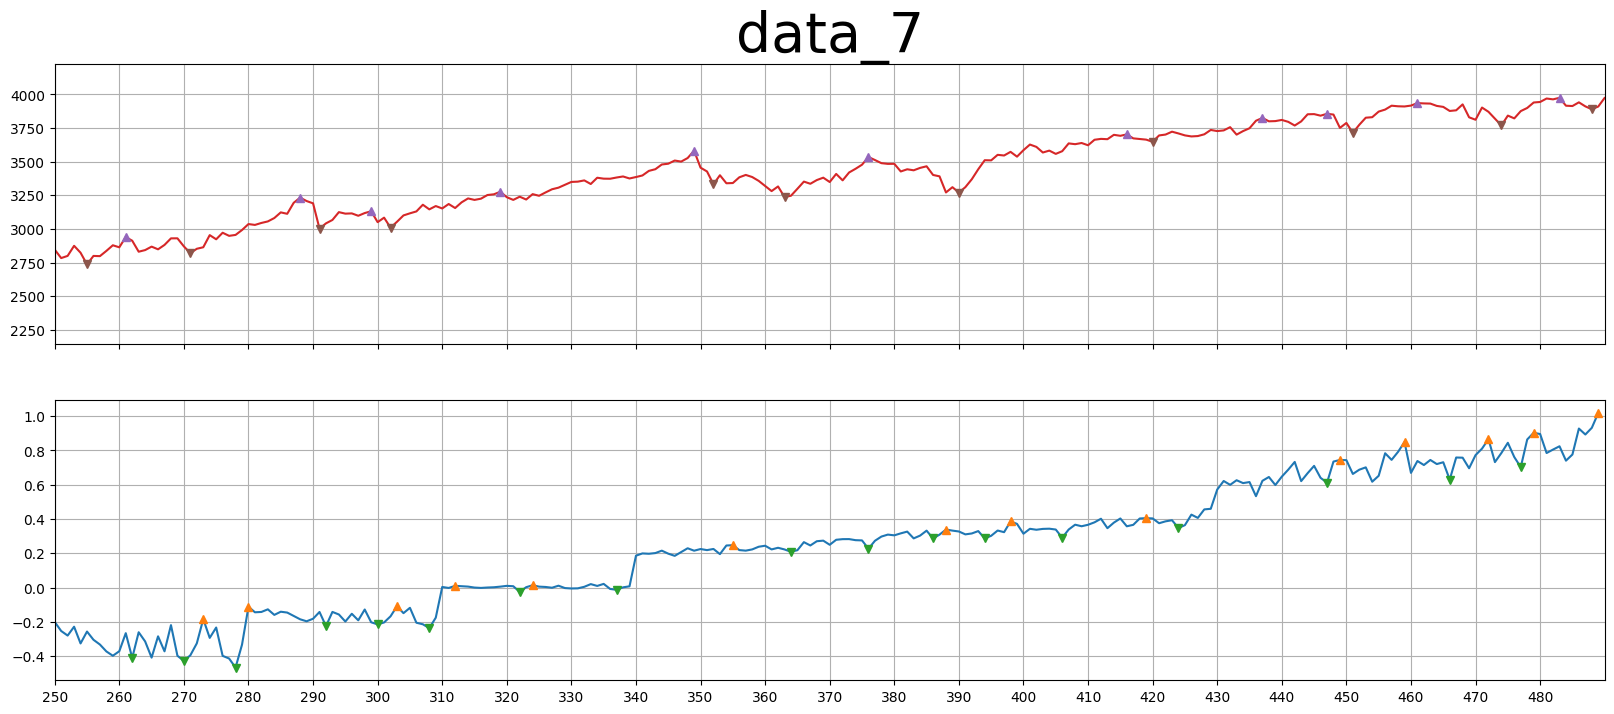

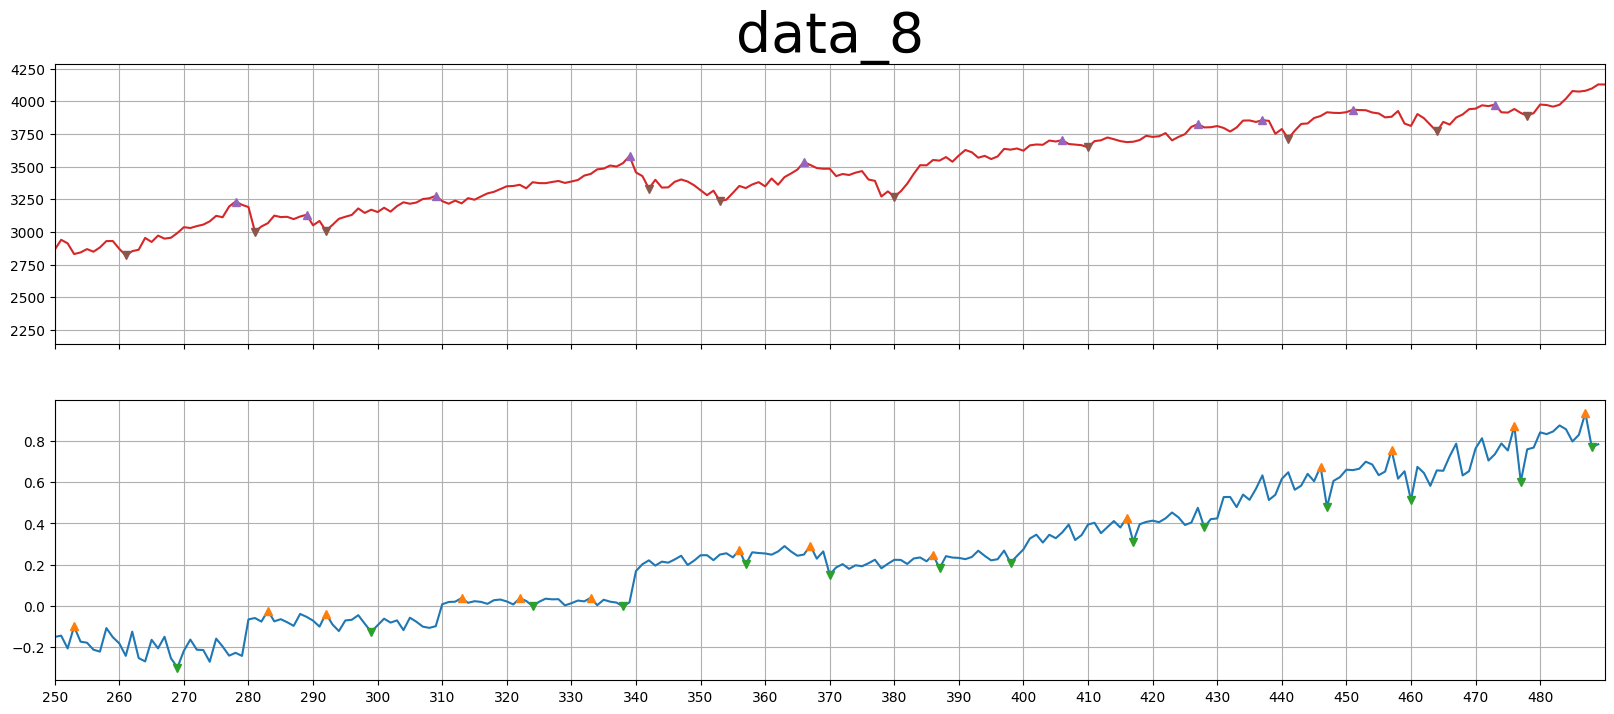

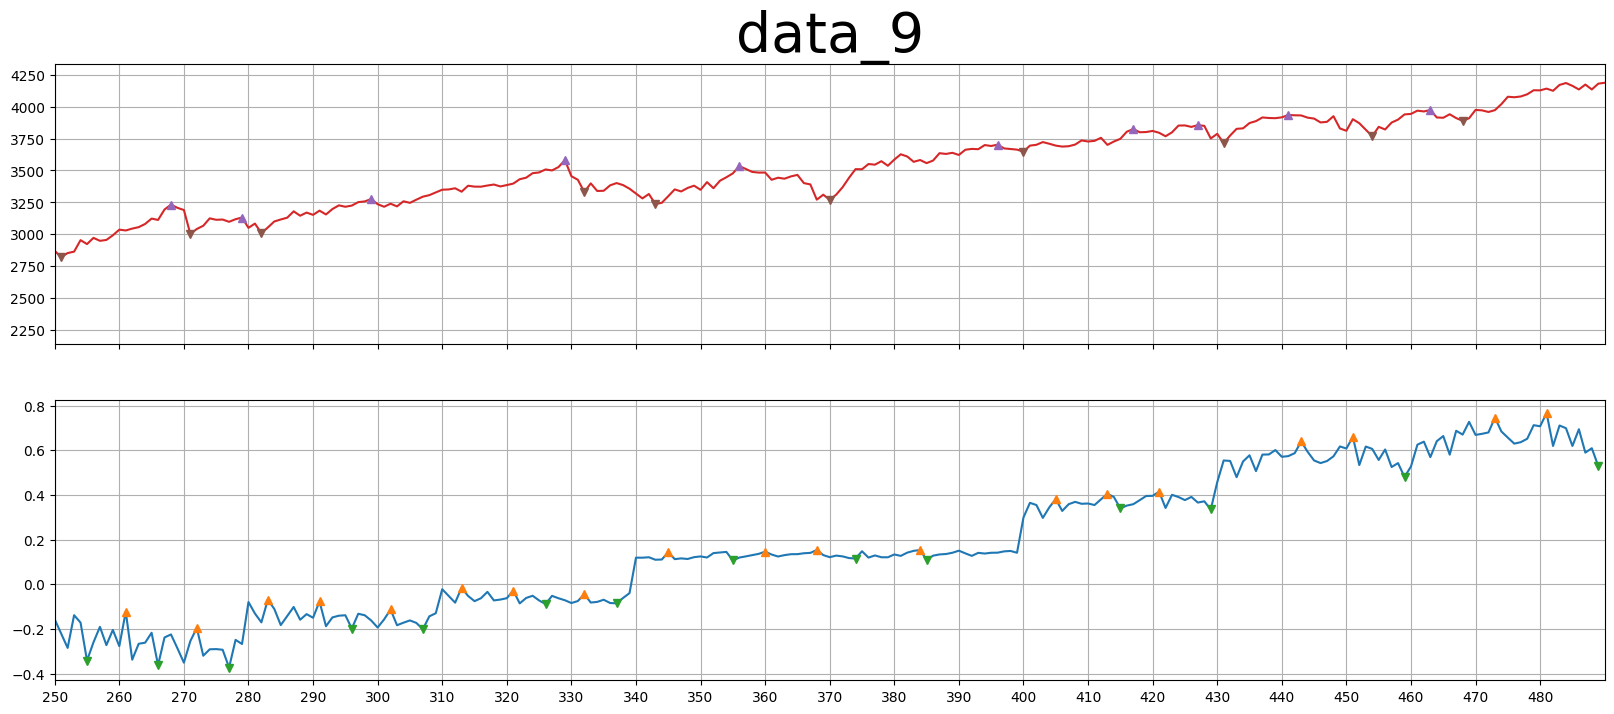

In [37]:
for i in processed_signal:
    fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    axes[0].set_title(i, fontsize=40)
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['Close'])
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['peaks'], '^')
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['valleys'], 'v')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['Close'])
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['peaks'], '^')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['valleys'], 'v')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['Close'])
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['peaks'], '^')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['valleys'], 'v')
    plt.xlim(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]))
    axes[0].grid()
    axes[1].grid()
    plt.xticks(np.arange(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]), step=10))
    plt.show()

In [38]:
def build_profit_table_method_1(result_table):
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        out_price = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range]
        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        profit_table.loc[i, 'out_date'] = result_table.loc[i, 't_date']+datetime.timedelta(days=pv_range)
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [39]:
total_profit, profit_table = build_profit_table_method_1(result_table)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = 378.450439453125
           in_date in_price    out_date out_price      pv  profit
data_0  2020-01-28  3276.24  2020-02-04   3345.78  valley   69.54
data_1  2020-01-17  3329.62  2020-01-24    3273.4    peak   56.22
data_2  2020-02-05  3334.69  2020-02-12   3380.16    peak  -45.47
data_3  2020-02-20  3373.23  2020-02-27   3090.23  valley  -283.0
data_4  2020-03-16  2386.13  2020-03-23   2475.56  valley   89.43
data_5  2020-03-17  2529.19  2020-03-24   2630.07  valley  100.88
data_6  2020-04-01   2470.5  2020-04-08   2761.63  valley  291.13
data_7  2020-04-30  2912.43  2020-05-07   2930.19  valley   17.76
data_8  2020-05-01  2830.71  2020-05-08   2870.12    peak  -39.41
data_9  2020-05-19  2922.94  2020-05-26   3044.31  valley  121.37


In [40]:
def draw_profit_plot(profit_table, pv_range):
    date_list = sorted(
        list(profit_table['in_date']) + list(profit_table['out_date']))
    plot_data = all_data.loc[date_list[0]:date_list[-1]]
    find_data_pv_function(plot_data, pv_range)
    plt.figure(figsize=(20, 8))
    plt.plot(plot_data['Close'], label='real data')
    plt.plot(plot_data['peaks'], '^', label='peaks', c='royalblue')
    plt.plot(plot_data['valleys'], 'v', label='valleys', c='orangered')
    j=0
    for i in profit_table.index:
        plt.plot(profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price'], '*', c='red')
        text = f'in_price_{j}:'+str(round(profit_table.loc[i, 'in_price'], 2))
        plt.annotate(text, (profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']-100), fontsize=14, c='red')

        plt.plot(profit_table.loc[i, 'out_date'], profit_table.loc[i, 'out_price'], '*', c='green')
        text = f'out_price_{j}:'+str(round(profit_table.loc[i, 'out_price'], 2))
        plt.annotate(text, (profit_table.loc[i, 'out_date'], profit_table.loc[i, 'out_price']+100), fontsize=14, c='green')
        j+=1

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.grid()
    plt.legend()
    plt.show()

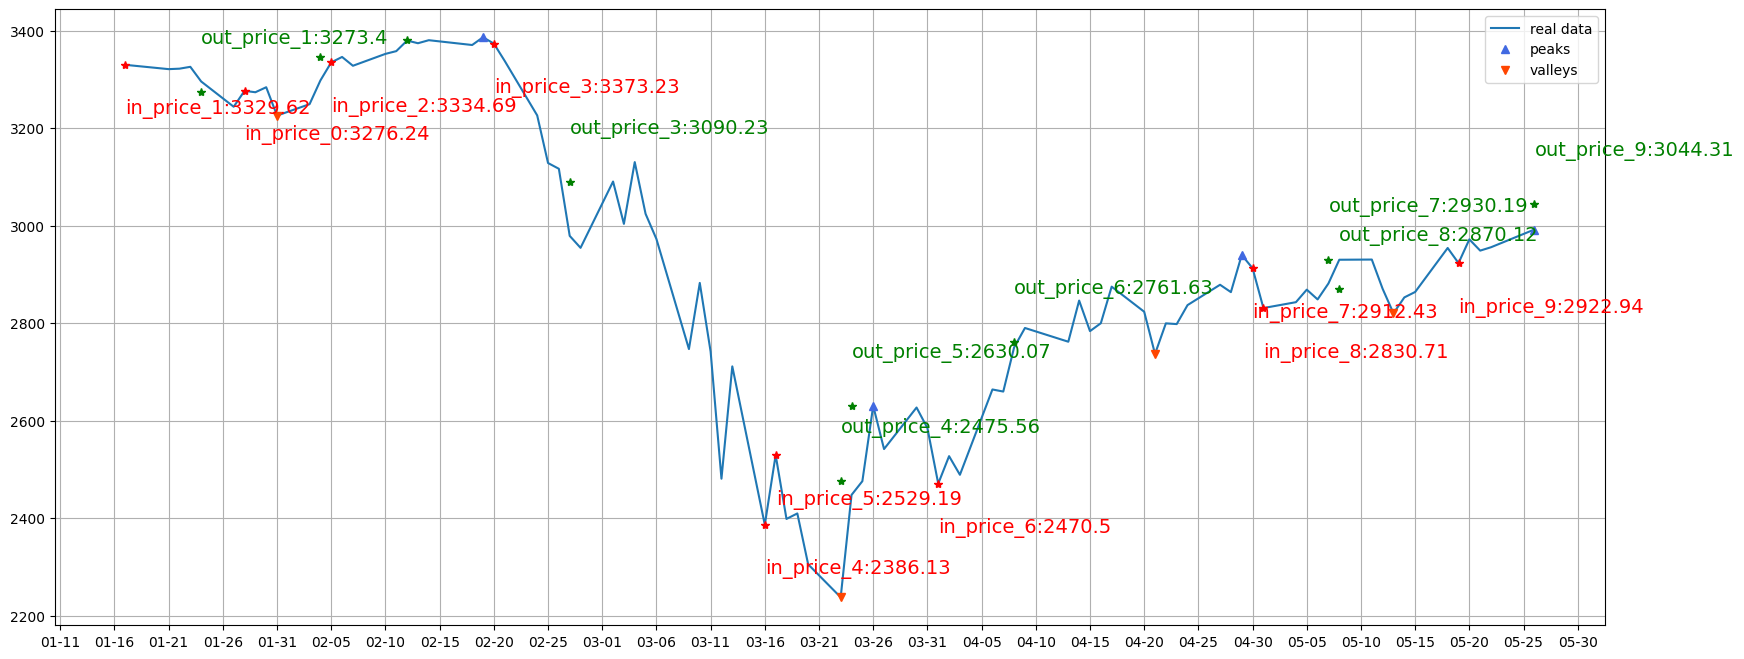

In [41]:
draw_profit_plot(profit_table, pv_range)